# Diffusion for 256 x 256

In [1]:
import jupyter_black

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision.utils import save_image
from torch.utils.data import DataLoader

from PIL import Image

import sys, os

if not "/usr/src" in sys.path:
    sys.path.append("/usr/src")

jupyter_black.load()

In [2]:
# Custom modules
from dataset import create_substrate_dataset, get_part_substrates_from_all
from unet import UNet
from diffusion import Diffusion
from utils.diffusion import show_samples, logging

In [3]:
# Dirs
substrate_dir = "/usr/src/substrates"
part_substrate_dir = "/usr/src/part_substrates"

image_size = 256

In [ ]:
# Cut part substrates
get_part_substrates_from_all(
    substrate_dir, part_substrate_dir, part_size=(image_size, image_size)
)

In [4]:
# Create dataset of the substrates
substrate_dataset = create_substrate_dataset(part_substrate_dir)

# Settings
channels = 1
batch_size = 10

# Create dataloader for training
train_loader = DataLoader(substrate_dataset, batch_size=batch_size, shuffle=True)

In [8]:
# Initialization of the denoising model and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet(img_dim=image_size, img_channels=channels)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
# Initialization of the diffusion
timesteps = 300
diffusion = Diffusion(timesteps)

In [10]:
epochs = 5
log_path = "logging"
log_interval = len(train_loader) // 5
n_log_samples = 16

for epoch in range(epochs):
    print(f"----- Epoch {epoch + 1} -----")
    for step, batch in enumerate(train_loader):
        optimizer.zero_grad()

        batch_size = batch.shape[0]
        batch = batch.to(device)

        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        loss = diffusion.p_losses(model, batch, t, loss_type="huber")

        if step % log_interval == 0:
            print("Loss:", loss.item())

        loss.backward()
        optimizer.step()

        batch = batch.to("cpu")

    logging(log_path, diffusion, model, epoch, n_log_samples, image_size, channels)

----- Epoch 1 -----
Loss: 0.45854663848876953
Loss: 0.02614029124379158
Loss: 0.0034581178333610296
Loss: 0.003193991957232356
Loss: 0.0028272513300180435


sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

----- Epoch 2 -----
Loss: 0.0032560292165726423
Loss: 0.00546810170635581
Loss: 0.0020655575208365917
Loss: 0.0009832641808316112
Loss: 0.012592959217727184


sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

----- Epoch 3 -----
Loss: 0.001292467932216823
Loss: 0.004608949180692434
Loss: 0.0011302623897790909
Loss: 0.011897498741745949
Loss: 0.0018841074779629707


sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

----- Epoch 4 -----
Loss: 0.003770426381379366
Loss: 0.005183489061892033
Loss: 0.007949359714984894
Loss: 0.003993242513388395
Loss: 0.0026401968207210302


sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

----- Epoch 5 -----
Loss: 0.0010628013405948877
Loss: 0.004122377373278141
Loss: 0.024549052119255066
Loss: 0.00256863865070045
Loss: 0.0030328489374369383


sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

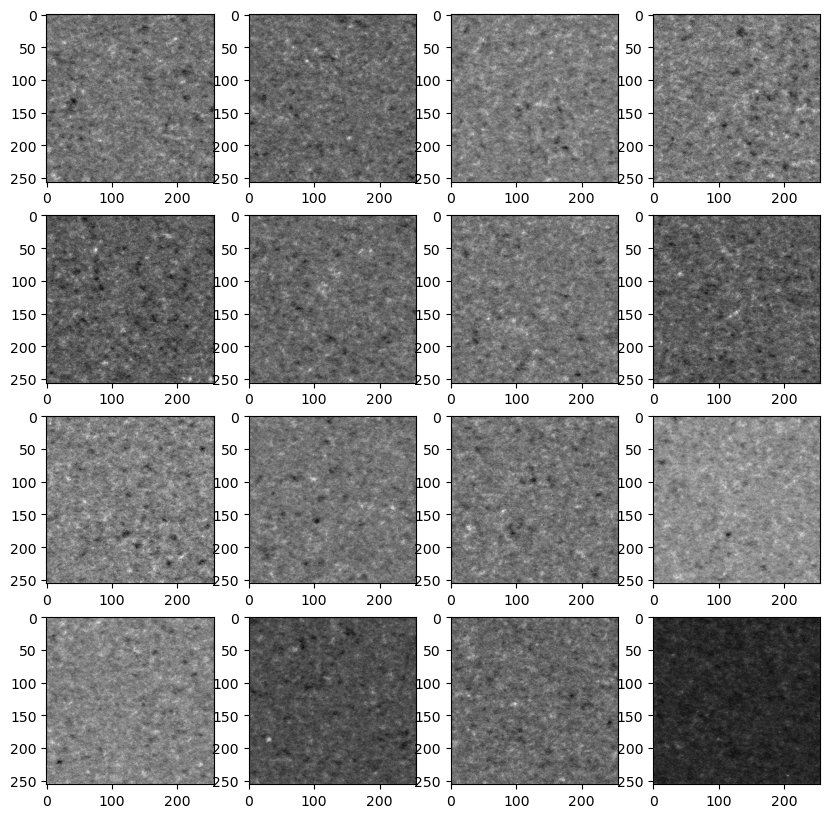

In [11]:
samples = show_samples(16, diffusion, model, image_size, channels)

In [ ]:
# show a random one
random_index = 0

plt.imshow(
    samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray"
)

In [ ]:
import matplotlib.animation as animation

fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(
        samples[i][random_index].reshape(image_size, image_size, channels),
        cmap="gray",
        animated=True,
    )
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save("diffusion.gif")
plt.show()